<div align="center" style="line-height: 1.7;">
    <h2 style="font-weight: 600;"><strong>Robustness & Generalization</strong></h2>
</div> 

&nbsp;


## 1) Import & Environment Setup

In [19]:
# ---  Notebook Setup ----------------------------------------------------
import sys, os
from pathlib import Path
from IPython import get_ipython
import importlib
import matplotlib.pyplot as plt
from dataclasses import dataclass, replace
from typing import Optional, List, Dict, Tuple
import numpy as np

GREEN = "\033[92m"; RED = "\033[91m"; RESET = "\033[0m"

try:
    root = Path.cwd()
    src_path = (root / "../src").resolve()

    # 1) Make sure local ../src wins over site-packages
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    ip = get_ipython()
    if ip:
        ip.run_line_magic("load_ext", "autoreload")
        ip.run_line_magic("autoreload", "2")

    # 2) Import and *verify* we’re loading the right files
    import rl_capstone
    import rl_capstone.rl_algorithms as rla
    print("rl_capstone from:", getattr(rl_capstone, "__file__", "?"))
    print("rl_algorithms from:", getattr(rla, "__file__", "?"))

    # 3) Force a reload in case kernel already loaded the old one
    importlib.reload(rla)

    # 4) Now import the names (after reload)
    from rl_capstone import GridWorld, WorldSettings
    
    from rl_capstone.rl_algorithms import (
        TrainConfig,
        q_learning_train_with_logs,
        sarsa_train_with_logs,
        dyna_q_train_with_logs,
    )
    from rl_capstone.utils import (
        evaluate_policy,
        greedy_policy_from_0,
        rolling,
    )


    print(f"{GREEN}Environment setup complete!{RESET}")

except Exception as e:
    print(f"{RED}Setup failed:{RESET}", e)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
rl_capstone from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/__init__.py
rl_algorithms from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/rl_algorithms.py
Environment setup complete!


## 2) Build & Preview Environment

States=121, Action4, Grid=11x11


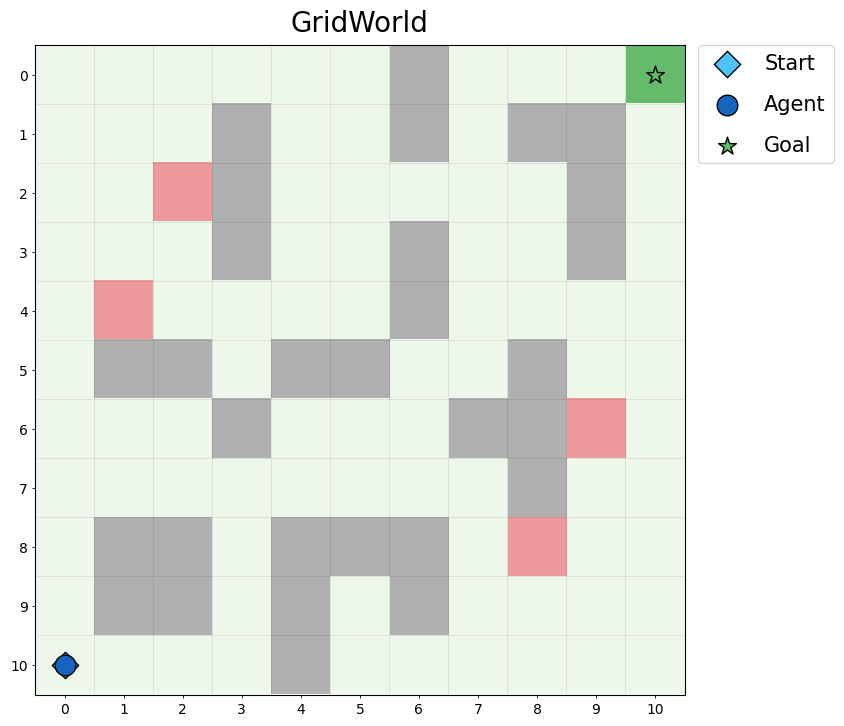

In [34]:
# Instantiate environment with your WorldSettings
settings = WorldSettings()      # tweak if you want a different map
env = GridWorld(settings)
env.seed(7)

print(f"States={env.num_states}, Action{env.num_actions}, Grid={env.rows}x{env.cols}")

env.render(title="GridWorld")

## 3) Trainer (with episode logging)

In [24]:
# Tweak depending on user preferences
@dataclass
class LogConfig:
    snapshot_every: int = 40    # take a snapshot every N episodes
    eval_episodes: int = 5      # greedy evals per snapshot
    seed: Optional[int] = 7

## 4) Train Configuration + Log Config

In [25]:
cfg = TrainConfig(
    episodes=750,
    max_steps=1000,
    alpha=0.10,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_steps=10_000,
    seed=42,
    q_init=0.0
)

logcfg = LogConfig(snapshot_every=40, eval_episodes=5, seed=7)

## 5) Import Q-Tables from `Comparison notebook`

In [26]:
paths = {
    "Q-Learning": "Q_q.npy",
    "SARSA": "Q_sarsa.npy",
    "Dyna-Q": "Q_dyna.npy"
}

results = {}
load_status = {}

for name, path in paths.items():
    try:
        Q = np.load(path)
        results[name] = {"Q": Q, "logs": None}
        load_status[name] = "OK"
    except Exception as e:
        load_status[name] = f"FAILED ({e.__class__.__name__})"

# --- Print summary table ---
print("\nLoad Summary:")
for k, v in load_status.items():
    if "OK" in v:
        print(f"{GREEN}{k:<12} : {v}{RESET}")
    else:
        print(f"{RED}{k:<12} : {v}{RESET}")

print("\nModels available:", list(results.keys()))



Load Summary:
Q-Learning   : OK
SARSA        : OK
Dyna-Q       : OK

Models available: ['Q-Learning', 'SARSA', 'Dyna-Q']


## 6) Helper Functions

In [67]:
ALGOS = {
    "Q-Learning": q_learning_train_with_logs,
    "SARSA":      sarsa_train_with_logs,
    "Dyna-Q":     dyna_q_train_with_logs,
}

def run_all_algorithms(env, cfg: TrainConfig, logcfg: LogConfig):
    results = {}
    for name, train_fn in ALGOS.items():
        print(f"\n=== Training {name} ===")
        Q, logs = train_fn(env, cfg, logcfg)
        results[name] = {"Q": Q, "logs": logs}
    return results

def plot_learning_curves(results_dict, title_prefix=""):
    plt.figure(figsize=(9,4))
    for name, res in results_dict.items():
        returns = res["logs"]["returns"]
        smooth = rolling(returns, 25)
        plt.plot(smooth, label=name, linewidth=2)
    plt.title(f"{title_prefix} — Return per Episode")
    plt.xlabel("Episode"); plt.ylabel("Return (rolling avg)")
    plt.grid(True); plt.legend()
    plt.show()

    plt.figure(figsize=(9,4))
    for name, res in results_dict.items():
        steps = res["logs"]["steps"]
        smooth = rolling(steps, 25)
        plt.plot(smooth, label=name, linewidth=2)
        plt.title(f"{title_prefix} — Episode Length")
    plt.xlabel("Episode"); plt.ylabel("Steps (rolling avg)")
    plt.grid(True); plt.legend()
    plt.show()

def greedy_eval_on_env(env, results_dict, cfg, desc=""):
    print(f"\nGreedy evaluation on: {desc}")
    print("-" * 60)
    for name, res in results_dict.items():
        Q = res["Q"]
        pi = greedy_policy_from_0(Q)
        mean_return, mean_length = evaluate_policy(
            env, pi, episodes=30, max_steps=cfg.max_steps, seed=123
        )
        print(f"{name:10s} | Return={mean_return:.3f} | Steps={mean_length:.1f}")

def seed_stability_experiment(env, base_cfg: TrainConfig, logcfg: LogConfig,
                              seeds: List[int], last_n: int = 50):
    """
    For each algorithm and each seed:
      - train once on `env` with cfg.seed = that seed
      - record average return / steps over the last `last_n` episodes

    Returns
    -------
    stats : dict[name] -> {"final_returns": [...], "final_steps": [...]}
    """
    stats = {
        name: {"final_returns": [], "final_steps": []}
        for name in ALGOS.keys()
    }

    for seed in seeds:
        print(f"\n### Seed = {seed} ###")
        cfg_seed = replace(base_cfg, seed=seed)
        for name, train_fn in ALGOS.items():
            print(f"  Training {name}...")
            Q, logs = train_fn(env, cfg_seed, logcfg)
            returns = logs["returns"]
            steps   = logs["steps"]

            # Average over last `last_n` episodes
            final_ret   = float(np.mean(returns[-last_n:]))
            final_steps = float(np.mean(steps[-last_n:]))

            stats[name]["final_returns"].append(final_ret)
            stats[name]["final_steps"].append(final_steps)
            
    return stats

## 7) Robustness to Transition Noise (winds)
The section provides a complete robustness study:

* **Zero-shot test:** How much performance drops when applying the original policies to a windier world.

* **Retraining test:** How quickly each algorithm adapts to noisy transitions when trained in that environment.

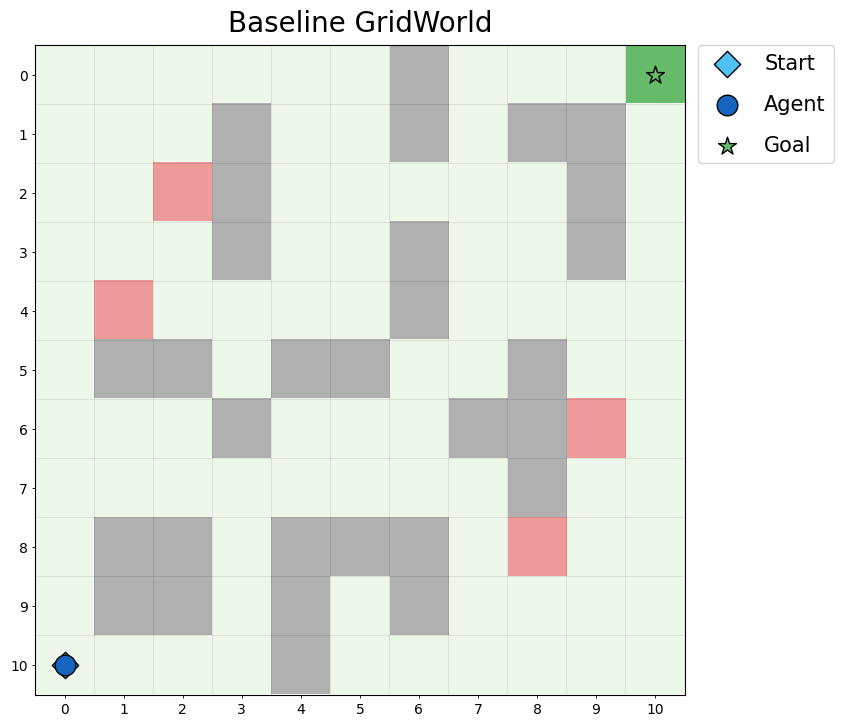

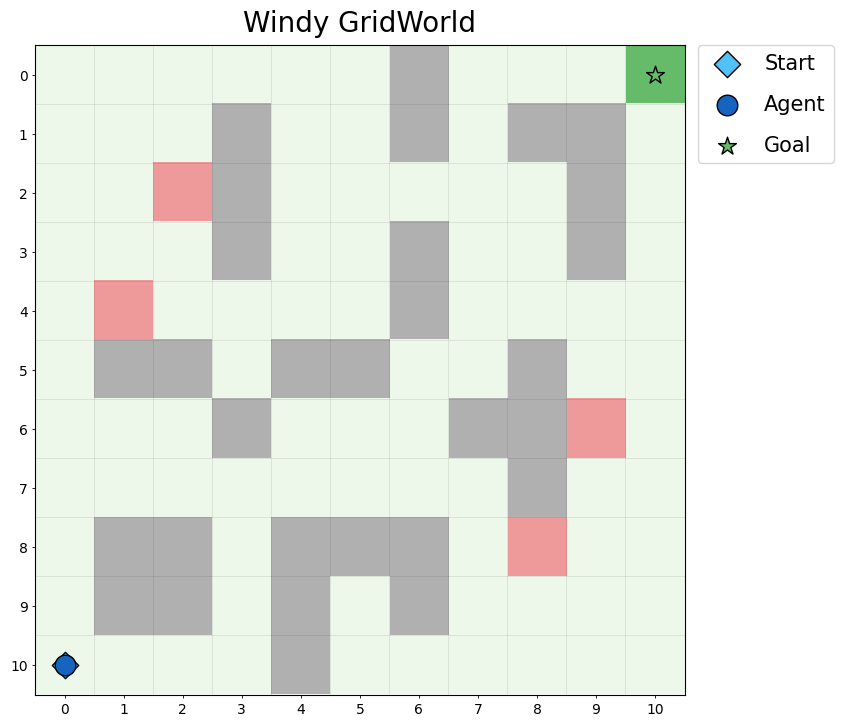


Greedy evaluation on: Windy env (policies trained on baseline env)
------------------------------------------------------------
Q-Learning | Return=0.680 | Steps=33.0
SARSA      | Return=0.679 | Steps=33.1
Dyna-Q     | Return=0.669 | Steps=34.1

Training all algorithms on windy env...

=== Training Q-Learning ===

=== Training SARSA ===

=== Training Dyna-Q ===


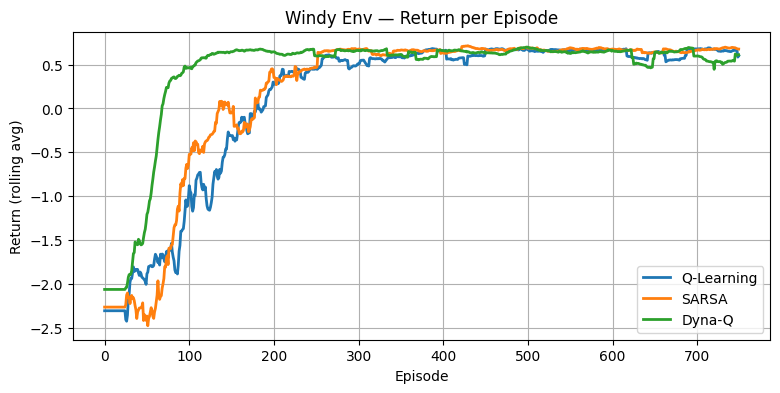

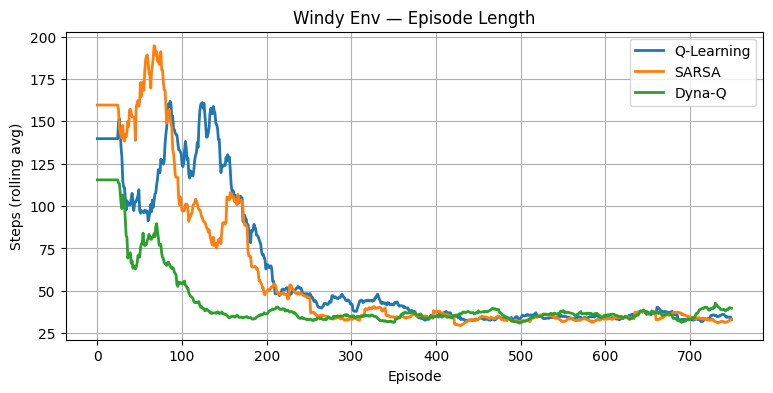


Greedy evaluation on: Windy env (policies trained on windy env)
------------------------------------------------------------
Q-Learning | Return=0.682 | Steps=32.8
SARSA      | Return=0.682 | Steps=32.8
Dyna-Q     | Return=0.674 | Steps=33.6


In [38]:
# 1) Windy environment (higher transition noise)
windy_settings = replace(settings, wind_chance=0.30)  # Change wind probability
env_windy = GridWorld(windy_settings)
env_windy.seed(7)

env.render(title="Baseline GridWorld")
env_windy.render(title="Windy GridWorld")

# 2) ZERO-SHOT ROBUSTNESS:
#    Evaluate PRETRAINED Q-tables (loaded from .npy) on the new windy env.
#    Here, `results` comes from:
#      Q_q = np.load("Q_q.npy"), etc.
#      results = {"Q-Learning": {"Q": Q_q, ...}, ...}
greedy_eval_on_env(
    env_windy,
    results,
    cfg,
    desc="Windy env (policies trained on baseline env)"
)

# 3) TRAINING FROM SCRATCH ON WINDY ENV:
#    This does *not* use the loaded Q-tables; it runs new training runs
#    of Q-learning, SARSA, and Dyna-Q directly on env_windy.
cfg_windy = replace(cfg, seed=42)

print("\nTraining all algorithms on windy env...")
windy_results = run_all_algorithms(env_windy, cfg_windy, logcfg)

plot_learning_curves(windy_results, title_prefix="Windy Env")

# 4) Evaluate the policies that were trained *on* the windy env
greedy_eval_on_env(
    env_windy,
    windy_results,
    cfg_windy,
    desc="Windy env (policies trained on windy env)"
)


### Path Visualization Windy Environment

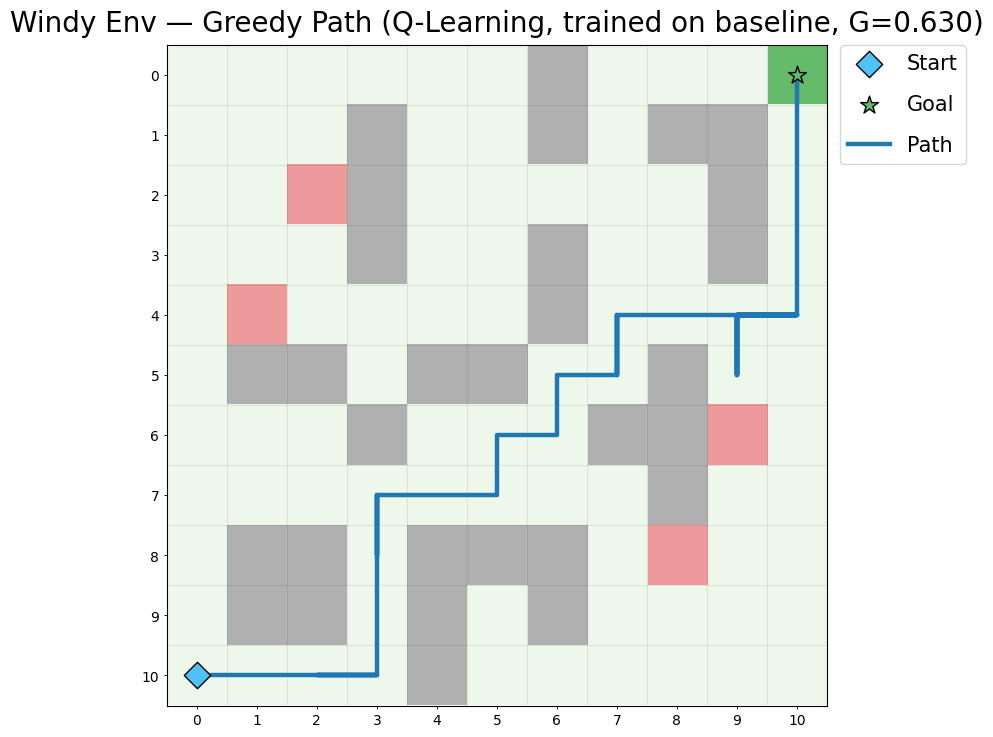

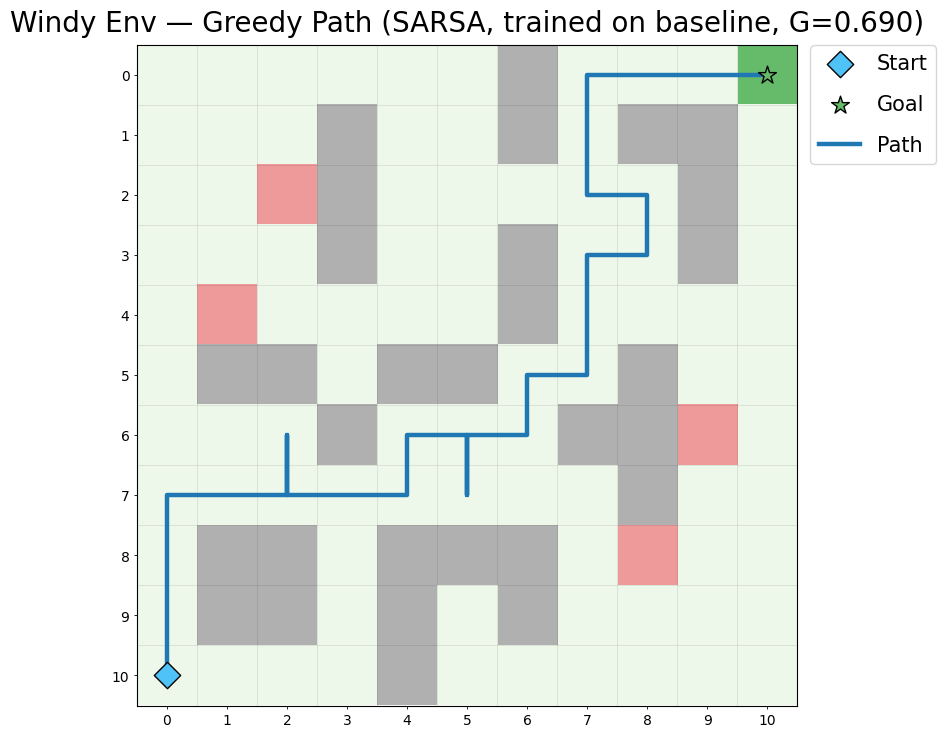

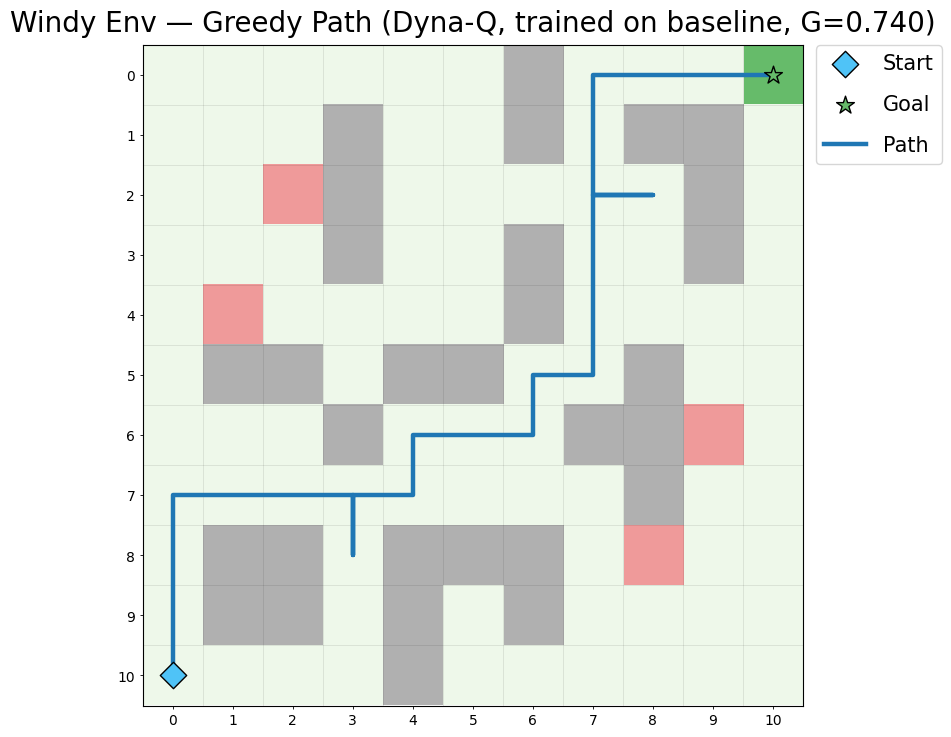

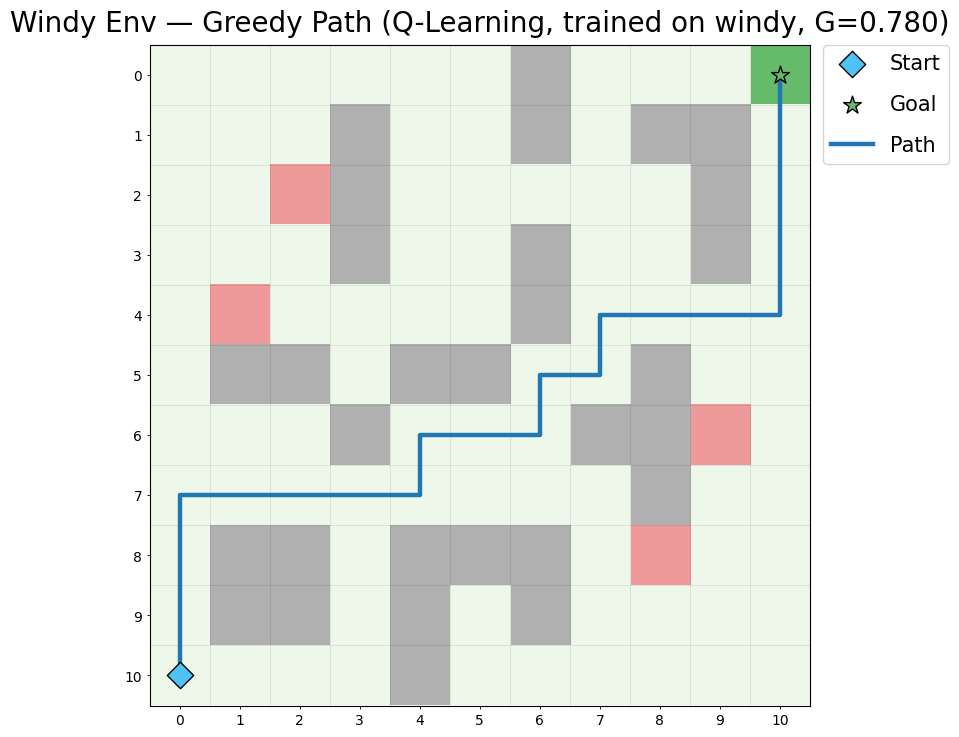

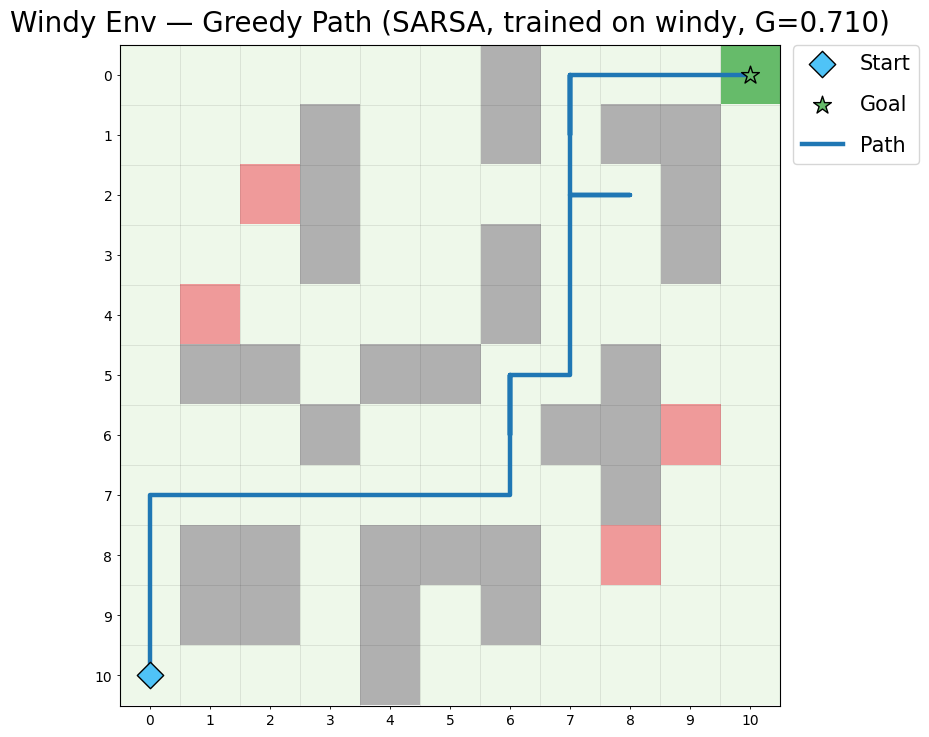

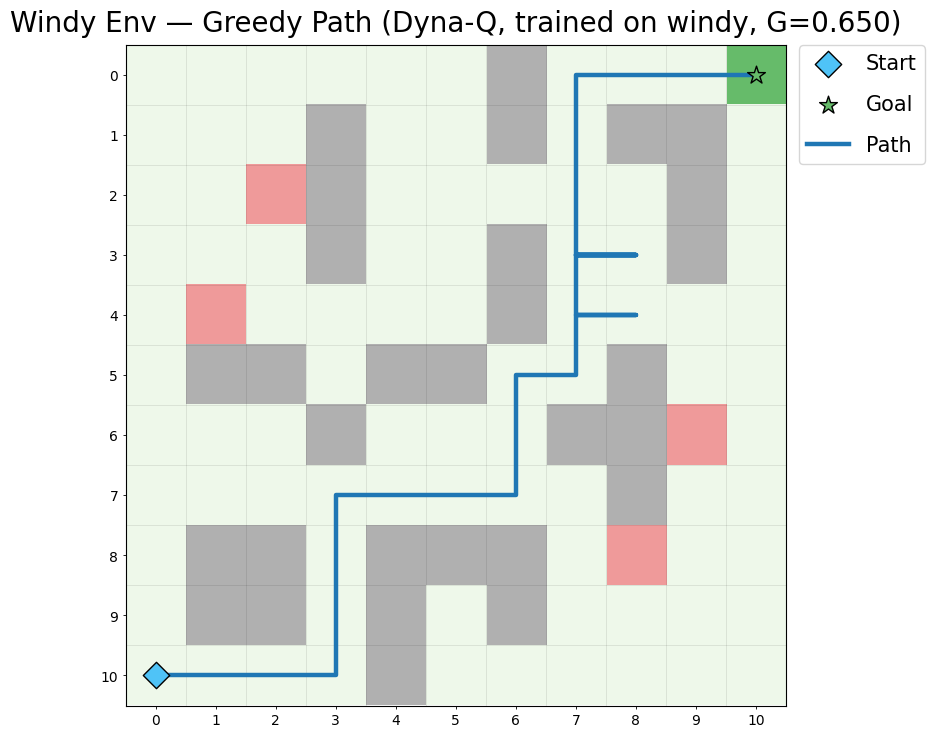

In [40]:
from rl_capstone.utils import run_greedy_episode, idx_traj_to_rc_path

# Paths in windy env – policies trained on baseline env
for name, res in results.items():
    Q = res["Q"]
    G, traj = run_greedy_episode(env_windy, Q, max_steps=cfg.max_steps)
    env_windy.reset()
    env_windy.render(
        path=idx_traj_to_rc_path(env_windy, traj),
        show_agent=False,
        title=f"Windy Env — Greedy Path ({name}, trained on baseline, G={G:.3f})"
    )

# Paths in windy env – policies trained on windy env
for name, res in windy_results.items():
    Q = res["Q"]
    G, traj = run_greedy_episode(env_windy, Q, max_steps=cfg_windy.max_steps)
    env_windy.reset()
    env_windy.render(
        path=idx_traj_to_rc_path(env_windy, traj),
        show_agent=False,
        title=f"Windy Env — Greedy Path ({name}, trained on windy, G={G:.3f})"
    )

## 8) Layout-Shift Robustness

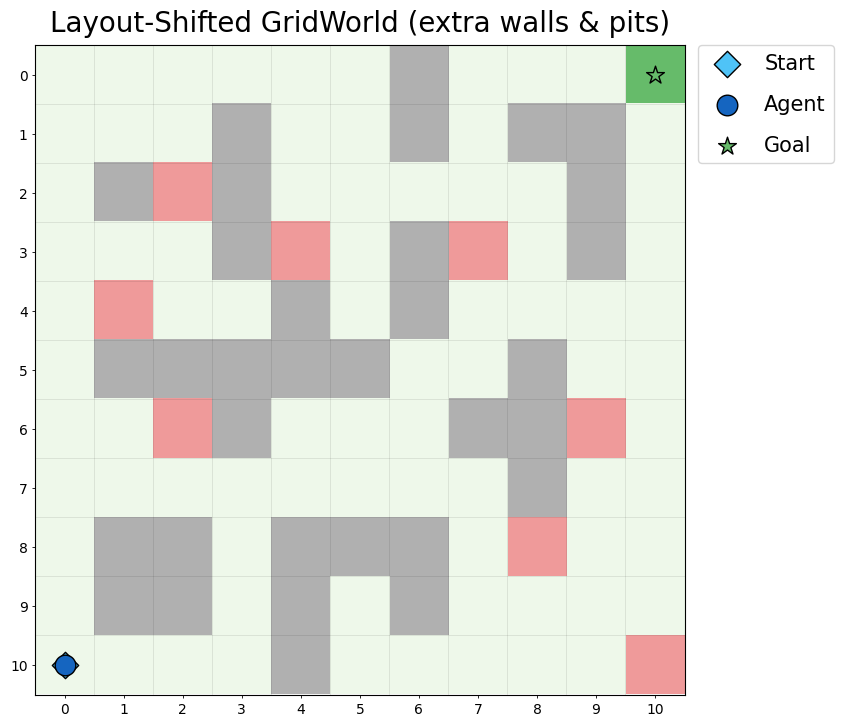


Greedy evaluation on: Layout-shifted env (policies trained on baseline)
------------------------------------------------------------
Q-Learning | Return=0.713 | Steps=23.0
SARSA      | Return=-1.147 | Steps=15.7
Dyna-Q     | Return=-1.154 | Steps=16.4

Training all algorithms on layout-shifted env...

=== Training Q-Learning ===

=== Training SARSA ===

=== Training Dyna-Q ===


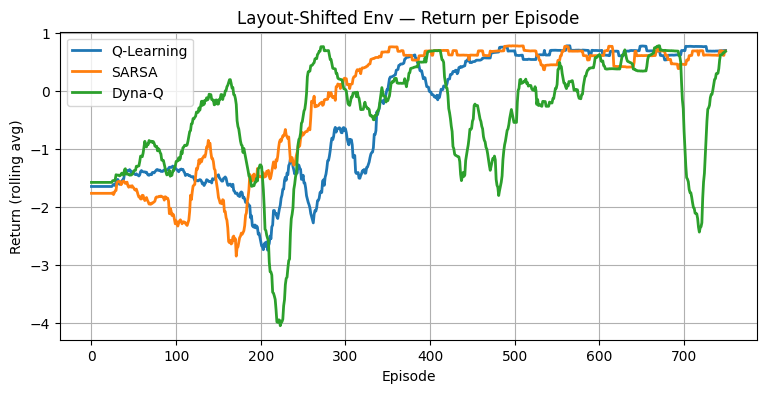

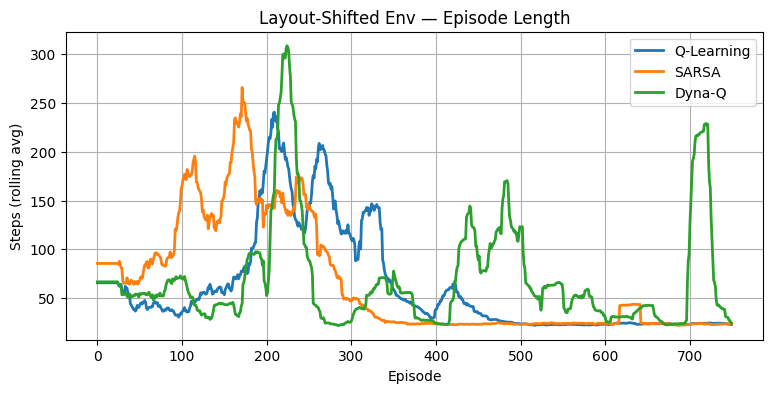


Greedy evaluation on: Layout-shifted env (policies trained on layout-shifted env)
------------------------------------------------------------
Q-Learning | Return=0.778 | Steps=23.2
SARSA      | Return=0.715 | Steps=22.8
Dyna-Q     | Return=0.715 | Steps=22.8


In [53]:
# Extra walls (chosen to tighten corridors but not block all paths, 
# pick cells that don’t block start/goal)
extra_walls = (
    # Near upper-left / mid-left
    (2, 1),
    # Thicken the central vertical spine around col=3
    (5, 3),
    # Add some central clutter
    (4, 4),
)

# Extra pits (bad “tempting” cells along likely routes)
extra_pits = (
    (3, 4),
    (6, 2),
    (10, 10),
    (3, 7),
)

# Combine with original settings
new_walls = settings.walls + extra_walls
new_pits  = settings.pits  + extra_pits

layout_settings = replace(settings, walls=new_walls, pits=new_pits)
env_layout = GridWorld(layout_settings)
env_layout.seed(7)

env_layout.render(title="Layout-Shifted GridWorld (extra walls & pits)")

# Zero-shot: baseline policies in new layout
greedy_eval_on_env(
    env_layout,
    results,
    cfg,
    desc="Layout-shifted env (policies trained on baseline)"
)

# Retrain on new layout
cfg_layout = replace(cfg, seed=42)
print("\nTraining all algorithms on layout-shifted env...")
layout_results = run_all_algorithms(env_layout, cfg_layout, logcfg)

plot_learning_curves(layout_results, title_prefix="Layout-Shifted Env")

greedy_eval_on_env(
    env_layout,
    layout_results,
    cfg_layout,
    desc="Layout-shifted env (policies trained on layout-shifted env)"
)


## 9) Seed Stability

### Seed Stability in Baseline & Windy Environment

In [70]:
seed_list = [0, 1, 2, 3, 4]   # more seeds = more compute, smoother stats

# Run Seed Stability functions
layout_stability = seed_stability_experiment(env_layout, cfg_layout, logcfg, seed_list, last_n=50)

print(f"{GREEN}\nTraining in Baseline Environment Completed!{RESET}")

windy_stability = seed_stability_experiment(env_windy, cfg_windy, logcfg, seed_list, last_n=50)

print(f"{GREEN}\nTraining in Windy Environment Completed!{RESET}")



### Seed = 0 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 1 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 2 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 3 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 4 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

Training in Baseline Environment Completed!

### Seed = 0 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 1 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 2 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 3 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

### Seed = 4 ###
  Training Q-Learning...
  Training SARSA...
  Training Dyna-Q...

Training in Windy Environment Completed!


### Summary + Bar Plot


Q-Learning
  Returns: mean=0.603, std=0.097
  Steps:   mean=24.7,  std=1.4


SARSA
  Returns: mean=0.587, std=0.046
  Steps:   mean=25.5,  std=1.8


Dyna-Q
  Returns: mean=0.095, std=0.325
  Steps:   mean=44.3,  std=10.2



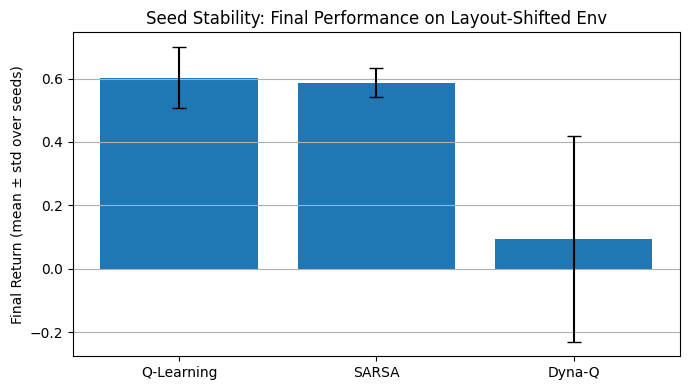

In [76]:
# === Layout-Shift Seed Stability ===

# Print numeric summary
for name, d in layout_stability.items():
    r = np.array(d["final_returns"])
    s = np.array(d["final_steps"])
    print(f"\n{name}")
    print(f"  Returns: mean={r.mean():.3f}, std={r.std():.3f}")
    print(f"  Steps:   mean={s.mean():.1f},  std={s.std():.1f}\n")


# Bar chart of final-return mean ± std
algo_names = list(layout_stability.keys())
means = [np.mean(layout_stability[a]["final_returns"]) for a in algo_names]
stds  = [np.std(layout_stability[a]["final_returns"])  for a in algo_names]

x = np.arange(len(algo_names))
plt.figure(figsize=(7,4))
plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, algo_names)
plt.ylabel("Final Return (mean ± std over seeds)")
plt.title("Seed Stability: Final Performance on Layout-Shifted Env")
plt.grid(axis="y")
plt.tight_layout()
plt.show()



Q-Learning
  Returns: mean=0.655, std=0.022
  Steps:   mean=34.7,  std=1.8


SARSA
  Returns: mean=0.668, std=0.007
  Steps:   mean=34.2,  std=0.7


Dyna-Q
  Returns: mean=0.605, std=0.027
  Steps:   mean=37.3,  std=1.7



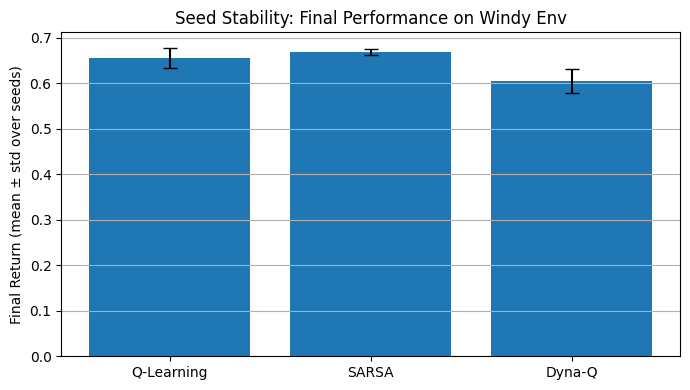

In [77]:
# === Windy-Env Seed Stability ===

# Print numeric summary
for name, d in windy_stability.items():
    r = np.array(d["final_returns"])
    s = np.array(d["final_steps"])
    print(f"\n{name}")
    print(f"  Returns: mean={r.mean():.3f}, std={r.std():.3f}")
    print(f"  Steps:   mean={s.mean():.1f},  std={s.std():.1f}\n")


# Bar chart of final-return mean ± std
algo_names = list(windy_stability.keys())
means = [np.mean(windy_stability[a]["final_returns"]) for a in algo_names]
stds  = [np.std(windy_stability[a]["final_returns"])  for a in algo_names]

x = np.arange(len(algo_names))
plt.figure(figsize=(7,4))
plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, algo_names)
plt.ylabel("Final Return (mean ± std over seeds)")
plt.title("Seed Stability: Final Performance on Windy Env")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [81]:
layout_stability["Dyna-Q"]["final_returns"]
layout_stability["Dyna-Q"]["final_steps"]

[32.18, 50.6, 32.34, 49.58, 56.86]